### 1. OD Matrix Algo
This script is focused on generating synthetic Origin-Destination (OD) data for Delhi Metro Magenta Line, incorporating elements like travel times, rush hour effects, and randomness to simulate realistic passenger flows, adding realistic time variability and passenger distribution along the route. 


(matchmaking for subway platforms)

In [2]:
import pandas as pd
import numpy as np
import random

# Define a function to adjust time strings based on an offset
def adjust_time(time_str, offset_seconds=0):
    time_str = time_str.strip()
    parts = time_str.split(':')
    hours, minutes, seconds = int(parts[0]), int(parts[1]), int(parts[2])
    if hours >= 24:            # Handle the next day scenario
        hours -= 24
    total_seconds = hours * 3600 + minutes * 60 + seconds + offset_seconds
    total_seconds %= 86400     # Wrap around a single day
    new_hours = total_seconds // 3600
    new_minutes = (total_seconds % 3600) // 60
    new_seconds = total_seconds % 60
    return f"{new_hours:02}:{new_minutes:02}:{new_seconds:02}"

# Load GTFS data for stops and stop times
stops_df = pd.read_csv('../transit_sim_inputs/gtfs_magenta_line_stops_14.csv')
stop_times_df = pd.read_csv('../transit_sim_inputs/gtfs_magenta_line_stop_times_14_upward.csv')

# Copy the values from the 'stop_name' column to the 'stop_id' column
stops_df['stop_id'] = stops_df['stop_name']
stop_times_df['stop_id'] = stop_times_df['stop_name']

# Correct and convert time data 
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))
stop_times_df['departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))
stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format='%H:%M:%S').dt.time
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format='%H:%M:%S').dt.time

# Introduce randomness to the times to simulate real-world variability
stop_times_df['adjusted_entry_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), -random.randint(120, 300)))
stop_times_df['adjusted_departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), random.randint(90, 180)))

# Convert adjusted times back to datetime for further analysis
stop_times_df['adjusted_entry_time'] = pd.to_datetime(stop_times_df['adjusted_entry_time'], format='%H:%M:%S').dt.time
stop_times_df['adjusted_departure_time'] = pd.to_datetime(stop_times_df['adjusted_departure_time'], format='%H:%M:%S').dt.time

# Calculate entry hours for rush hour weight calculation
stop_times_df['entry_hours'] = stop_times_df['adjusted_entry_time'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# Total passengers and rush hour setup
total_passengers = 331710                       # (5,92,338/25)*14 = 331710
rush_hour_multiplier = 1.5
rush_hours = [(8, 10), (17, 20)]

# Calculate weights for each hour to apply rush hour multipliers.
def calculate_weights(entry_hours, rush_hours, multiplier):
    weights = []
    for hour in entry_hours:
        weight = 1
        for start, end in rush_hours:
            if start <= hour <= end:
                weight = multiplier
                break
        weights.append(weight)
    return np.array(weights)

# Calculate weights for each entry time
stop_times_df['weights'] = calculate_weights(stop_times_df['entry_hours'], rush_hours, rush_hour_multiplier)

# Stop IDs and OD matrix setup
stop_ids = stops_df['stop_id']
od_matrix = pd.DataFrame(data=0, index=stop_ids, columns=stop_ids)

# Simulate passenger distribution among stops
passenger_distribution = []
for i, origin in enumerate(stop_ids):
    for j, destination in enumerate(stop_ids):
        if i < j:  # Ensure passengers in one direction along the route
            passenger_distribution.append((origin, destination))

# Stop s and OD matrix setup
stop_ids = stops_df['stop_id']
od_matrix = pd.DataFrame(data=0, index=stop_ids, columns=stop_ids)

# Simulate passenger distribution among stops
passenger_distribution = []
for i, origin in enumerate(stop_ids):
    for j, destination in enumerate(stop_ids):
        if i < j:  # Ensure passengers in one direction along the route
            passenger_distribution.append((origin, destination))

# Randomly assign passengers to these pairs
selected_pairs = random.choices(passenger_distribution, k=total_passengers)
for pair in selected_pairs:
    od_matrix.loc[pair[0], pair[1]] += 1

# Display the OD matrix
display(od_matrix)

# Function to generate detailed OD pairs from matrix
# Generating OD pairs— (matchmaking for bus stops!)
def generate_od_pairs_from_matrix(od_matrix, stop_times_df):
    od_pairs = []
    for origin in od_matrix.index:
        for destination in od_matrix.columns:
            if od_matrix.loc[origin, destination] > 0:      # Check if there are passengers traveling from origin to destination
                num_passengers = od_matrix.loc[origin, destination]
                for _ in range(num_passengers):
                    #Since origin and destintion are already defined according to od_matrix, 
                    #so creating the dataframe of records that have 'origin' and 'destination' as 'stop_id' in stop_times_file respectively
                    # or (Filter stop_times_df for records matching the origin and destination stops)
                    origin_times = stop_times_df[stop_times_df['stop_id'] == origin]  
                    destination_times = stop_times_df[stop_times_df['stop_id'] == destination]
                    
                    # Proceed only if both origin and destination have some records
                    if not origin_times.empty and not destination_times.empty:
                        # Randomly select an entry record from origin_times, weighted by rush hour factors
                        entry_record = origin_times.sample(n=1, weights='weights') 

                        # Find matching destination times with the same trip_id as the selected entry record
                        # or [Creating a df (from the df of destination_times) of potential_dest_times based on the same trip_id as entry_record ]
                        # (In this case, it will only be one as destination and trip_id has been fixed; can be zero also)
                        potential_dest_times = destination_times[(destination_times['trip_id'] == entry_record['trip_id'].iloc[0])] 

                        # Proceed only if there is a matching destination time for the selected trip_id
                        if not potential_dest_times.empty:
                            # Randomly select a matching destination time
                            deal_record = potential_dest_times.sample(n=1)

                            # Convert the selected entry and destination times to datetime objects
                            entry_datetime = pd.to_datetime(entry_record['adjusted_entry_time'].iloc[0], format='%H:%M:%S')
                            deal_datetime = pd.to_datetime(deal_record['adjusted_departure_time'].iloc[0], format='%H:%M:%S')

                            # Calculate the travel time in minutes
                            travel_time = round((deal_datetime - entry_datetime).total_seconds() / 60)

                            # Only consider valid trips where travel time is non-negative
                            if travel_time >= 0:
                                # Append the OD pair with all relevant details to the od_pairs list
                                od_pairs.append({
                                    'date': '08-20-2023',
                                    'hour': entry_datetime.hour,
                                    'entry_time': entry_datetime.strftime('%H:%M:%S'),
                                    'deal_time': deal_datetime.strftime('%H:%M:%S'),
                                    'enter_station': origin,
                                    'exit_station': destination,
                                    'travel_time': travel_time,
                                    'exit_type': 0,
                                    'departure_time': deal_datetime.strftime('%H:%M:%S'),
                                    # 'route_num': entry_record['route_num'].values[0],
                                    'route_id': entry_record['route_id'].values[0],
                                    'stop_sequence': entry_record['stop_sequence'].values[0]
                                })
    return pd.DataFrame(od_pairs)

# Save data
od_data = generate_od_pairs_from_matrix(od_matrix, stop_times_df)
od_data.to_csv('../inputs/od_magenta_line_14.csv', index=False)
print("OD data generated and saved. Shape:", od_data.shape)

stop_id,Botanical Garden,Okhla Bird Sanctuary,Kalindi Kunj,Jasola Vihar Shaheen Bagh,Okhla Vihar,Jamia Millia Islamia,Sukhdev Vihar,Okhla NSIC,Kalkaji Mandir,Nehru Enclave,Greater Kailash,Chirag Delhi,Panchsheel Park,Hauz Khas
stop_id,,,,,,,,,,,,,,
Botanical Garden,0,3652,3609,3747,3748,3641,3637,3496,3496,3637,3675,3579,3688,3617
Okhla Bird Sanctuary,0,0,3685,3530,3668,3622,3701,3601,3611,3727,3626,3632,3692,3551
Kalindi Kunj,0,0,0,3754,3720,3701,3624,3592,3675,3661,3662,3622,3673,3565
Jasola Vihar Shaheen Bagh,0,0,0,0,3585,3695,3719,3627,3595,3573,3635,3647,3742,3539
Okhla Vihar,0,0,0,0,0,3702,3701,3522,3606,3668,3620,3564,3626,3583
Jamia Millia Islamia,0,0,0,0,0,0,3680,3673,3620,3648,3667,3696,3672,3661
Sukhdev Vihar,0,0,0,0,0,0,0,3670,3549,3705,3560,3785,3641,3669
Okhla NSIC,0,0,0,0,0,0,0,0,3630,3643,3656,3566,3773,3595
Kalkaji Mandir,0,0,0,0,0,0,0,0,0,3699,3591,3621,3637,3603


OD data generated and saved. Shape: (331710, 11)


### 2. Rush hour check
This code calculates and visualizes the number of travelers entering at various times, particularly during defined morning and evening rush hours.

Number of travelers between 08:00:00 and 10:00:00: 55271
Number of travelers between 17:00:00 and 20:00:00: 84566
Total number of travelers during rush hours (morning + evening): 139837
Total travelers in the day: 331710


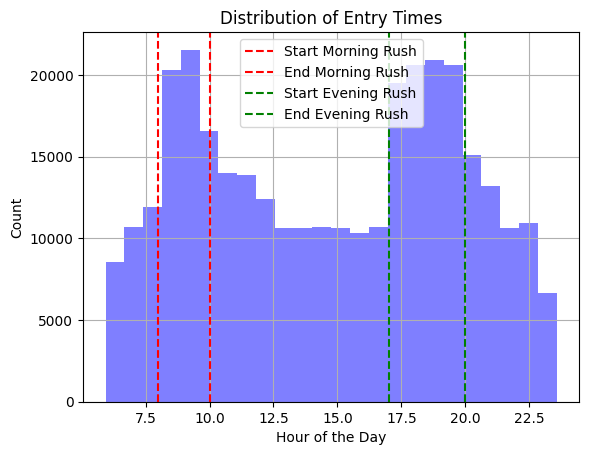

In [3]:
import matplotlib.pyplot as plt
times_df = pd.read_csv('../inputs/od_magenta_line_14.csv')

# Convert adjusted_entry_time to datetime.time for easier manipulation
times_df['adjusted_entry_time_dt'] = pd.to_datetime(times_df['entry_time'], format='%H:%M:%S').dt.time

# Define the morning and evening time ranges
start_time_morning = pd.to_datetime('08:00:00', format='%H:%M:%S').time()
end_time_morning = pd.to_datetime('10:00:00', format='%H:%M:%S').time()
start_time_evening = pd.to_datetime('17:00:00', format='%H:%M:%S').time()
end_time_evening = pd.to_datetime('20:00:00', format='%H:%M:%S').time()

# Filter entries within the specified morning and evening time ranges
filtered_entries_morning = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_morning) & (times_df['adjusted_entry_time_dt'] <= end_time_morning)]
filtered_entries_evening = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_evening) & (times_df['adjusted_entry_time_dt'] <= end_time_evening)]

# Combine morning and evening entries for total rush hour count
combined_rush_hour_entries = pd.concat([filtered_entries_morning, filtered_entries_evening])

# Count the number of entries
entry_count_morning = len(filtered_entries_morning)
entry_count_evening = len(filtered_entries_evening)
total_rush_hour_entries = len(combined_rush_hour_entries)
total_entries = len(times_df)

print(f'Number of travelers between {start_time_morning} and {end_time_morning}: {entry_count_morning}')
print(f'Number of travelers between {start_time_evening} and {end_time_evening}: {entry_count_evening}')
print(f'Total number of travelers during rush hours (morning + evening): {total_rush_hour_entries}')
print(f'Total travelers in the day: {total_entries}')

# Optionally, you can visualize the distribution of entry times
times_in_hours = times_df['adjusted_entry_time_dt'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
plt.hist(times_in_hours, bins=24, alpha=0.5, color='blue')
plt.title('Distribution of Entry Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.axvline(x=8, color='r', linestyle='--', label='Start Morning Rush')
plt.axvline(x=10, color='r', linestyle='--', label='End Morning Rush')
plt.axvline(x=17, color='g', linestyle='--', label='Start Evening Rush')
plt.axvline(x=20, color='g', linestyle='--', label='End Evening Rush')
plt.legend()
plt.grid(True)
plt.show()

### 2'. Faraz's Algo
This code snippet creates synthetic Origin-Destination (OD) pairs for Toronto's Subway Line 2. It adds realistic variability to travel times and passenger distributions, taking into account rush hour dynamics.

In [24]:
import pandas as pd
import numpy as np
import random

def adjust_time(time_str, offset_seconds=0):
    # This function now handles the time adjustment with a default offset of zero.
    time_str = time_str.strip()
    parts = time_str.split(':')
    hours, minutes, seconds = int(parts[0]), int(parts[1]), int(parts[2])
    if hours >= 24:  # Correct hours that roll over
        hours -= 24
    # Calculate total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds + offset_seconds
    total_seconds %= 86400  # Wrap around midnight
    new_hours = total_seconds // 3600
    new_minutes = (total_seconds % 3600) // 60
    new_seconds = total_seconds % 60
    return f"{new_hours:02}:{new_minutes:02}:{new_seconds:02}"

# Load data
stops_df = pd.read_csv('../inputs/gtfs_line_2_stops_upward_12.csv')
stop_times_df = pd.read_csv('../inputs/gtfs_line_2_stop_times_upward_12.csv')

# Correct and convert time data for accurate calculations
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Adjust without offset
stop_times_df['departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Initially the same as arrival

stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format='%H:%M:%S').dt.time
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format='%H:%M:%S').dt.time

# Introduce variability in entry and departure times to simulate real-world randomness
stop_times_df['adjusted_entry_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), -random.randint(120, 300)))
stop_times_df['adjusted_departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), random.randint(90, 300)))

# Convert the adjusted times back to datetime.time
stop_times_df['adjusted_entry_time'] = pd.to_datetime(stop_times_df['adjusted_entry_time'], format='%H:%M:%S').dt.time
stop_times_df['adjusted_departure_time'] = pd.to_datetime(stop_times_df['adjusted_departure_time'], format='%H:%M:%S').dt.time

# Define simulation parameters
total_passengers = 500000
rush_hour_multiplier = 3
rush_hours = [(6.5, 9.5), (15.5, 18.5)]

def calculate_weights(times, rush_hours, multiplier):
    # Convert datetime.time objects to hours as floats for easier comparison
    hours = times.apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
    
    # Initialize weights to 1
    weights = np.ones(len(times))
    
    # Apply rush hour multiplier
    for start, end in rush_hours:
        # Update weights for times within rush hour periods
        weights[(hours >= start) & (hours <= end)] *= multiplier
    
    return weights

def generate_od_pairs(num_trips, stop_times, rush_hours, rush_hour_multiplier):
    od_pairs = []
    for _ in range(num_trips):
        # Convert adjusted entry times to datetime.time for proper comparison
        stop_times['adjusted_entry_time_dt'] = pd.to_datetime(stop_times['adjusted_entry_time'], format='%H:%M:%S').dt.time
        
        # Calculate weights based on rush hours
        weights = calculate_weights(stop_times['adjusted_entry_time_dt'], rush_hours, rush_hour_multiplier)
        
        # Sample an entry record with weighted probabilities
        entry_record = stop_times.sample(1, weights=weights) ##choosing entry_record on the basis of rush hour (Bias sampling by rush hour)
        origin = entry_record['stop_id'].iloc[0]  ## taking stop_id of the chosen entry_record as origin
        trip_id = entry_record['trip_id'].iloc[0] ## extracting trip_id of the entry_record (It will help in choosing destination)
        stop_sequence = entry_record['stop_sequence'].iloc[0] ## extracting stop_seq of the entry_record (It will help in choosing destination)
        entry_datetime = pd.to_datetime(entry_record['adjusted_entry_time'].iloc[0], format='%H:%M:%S')

        # Filter for potential destination stops that match the same trip_id
        potential_destinations = stop_times[
            (stop_times['trip_id'] == trip_id) 
            # &
            # (stop_times['stop_sequence'] > stop_sequence)  ## Not checking for stop_seq here, to have a real-world distribution of entry and exit stops
        ]                                                    ## because if we check here, it fill find correct potential_destinations for every entry_stop
                                                             ## but in reality, entry_stops that are at ends will have lesser passengers
        if not potential_destinations.empty:
            potential_dest = potential_destinations.sample(1)
            # Avoid selecting a destination with an earlier stop_sequence than the origin
            if (potential_dest['stop_sequence'].iloc[0] < stop_sequence): ## checking here, because those entry_stops which are at the end have lesser chances to get selected 
                continue
            deal_record = potential_dest
            destination = deal_record['stop_id'].iloc[0] # Get the destination stop_id
            deal_datetime = pd.to_datetime(deal_record['adjusted_departure_time'].iloc[0], format='%H:%M:%S')

            travel_time = round((deal_datetime - entry_datetime).total_seconds() / 60)
            if travel_time >= 0:  # Only include valid travel times
                od_pairs.append({
                    'date': '2024-07-09',
                    'weekday': 2,
                    'hour': entry_datetime.hour,
                    'entry_time': entry_datetime.strftime('%H:%M:%S'),
                    'deal_time': deal_datetime.strftime('%H:%M:%S'),
                    'enter_station': origin,
                    'exit_station': destination,
                    'travel_time': travel_time,
                    'exit_type': 0,
                    'departure_time': deal_datetime.strftime('%H:%M:%S'),
                    # 'route_num': entry_record['route_num'].values[0],
                    'route_id': entry_record['route_id'].values[0],
                    'stop_num': entry_record['stop_num'].values[0]
                })

    # Convert the list of OD pairs to a DataFrame and return it
    return pd.DataFrame(od_pairs)

# Generate OD pairs for all passengers, considering rush and non-rush hours
od_data = generate_od_pairs(total_passengers, stop_times_df, rush_hours, rush_hour_multiplier)

# Save the generated OD data to a CSV file
od_data.to_csv('../inputs/Faraz_od_line_2_weekday_12.csv', index=False)
print("Synthetic OD data generated and saved. Shape:", od_data.shape)

Synthetic OD data generated and saved. Shape: (271204, 12)


### 2'. Rush hour check
This code calculates and visualizes the number of travelers entering at various times, particularly during defined morning and evening rush hours.

Number of travelers between 07:00:00 and 09:00:00: 70133
Number of travelers between 15:30:00 and 18:00:00: 64448
Total number of travelers during rush hours (morning + evening): 134581
Total travelers in the day: 271204


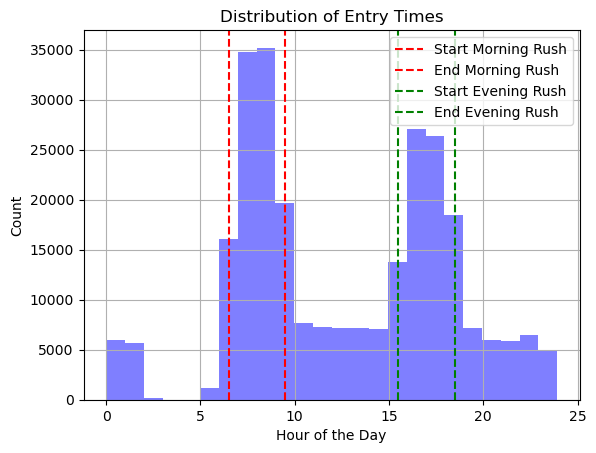

In [3]:
import matplotlib.pyplot as plt
times_df = pd.read_csv('../inputs/Faraz_od_line_2_weekday_12.csv')

# Convert adjusted_entry_time to datetime.time for easier manipulation
times_df['adjusted_entry_time_dt'] = pd.to_datetime(times_df['entry_time'], format='%H:%M:%S').dt.time

# Define the morning and evening time ranges
start_time_morning = pd.to_datetime('07:30:00', format='%H:%M:%S').time()
end_time_morning = pd.to_datetime('09:30:00', format='%H:%M:%S').time()
start_time_evening = pd.to_datetime('15:30:00', format='%H:%M:%S').time()
end_time_evening = pd.to_datetime('18:30:00', format='%H:%M:%S').time()

# Filter entries within the specified morning and evening time ranges
filtered_entries_morning = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_morning) & (times_df['adjusted_entry_time_dt'] <= end_time_morning)]
filtered_entries_evening = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_evening) & (times_df['adjusted_entry_time_dt'] <= end_time_evening)]

# Combine morning and evening entries for total rush hour count
combined_rush_hour_entries = pd.concat([filtered_entries_morning, filtered_entries_evening])

# Count the number of entries
entry_count_morning = len(filtered_entries_morning)
entry_count_evening = len(filtered_entries_evening)
total_rush_hour_entries = len(combined_rush_hour_entries)
total_entries = len(times_df)

print(f'Number of travelers between {start_time_morning} and {end_time_morning}: {entry_count_morning}')
print(f'Number of travelers between {start_time_evening} and {end_time_evening}: {entry_count_evening}')
print(f'Total number of travelers during rush hours (morning + evening): {total_rush_hour_entries}')
print(f'Total travelers in the day: {total_entries}')

# Optionally, you can visualize the distribution of entry times
times_in_hours = times_df['adjusted_entry_time_dt'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
plt.hist(times_in_hours, bins=24, alpha=0.5, color='blue')
plt.title('Distribution of Entry Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.axvline(x=6.5, color='r', linestyle='--', label='Start Morning Rush')
plt.axvline(x=9.5, color='r', linestyle='--', label='End Morning Rush')
plt.axvline(x=15.5, color='g', linestyle='--', label='Start Evening Rush')
plt.axvline(x=18.5, color='g', linestyle='--', label='End Evening Rush')
plt.legend()
plt.grid(True)
plt.show()

### 3. Departure time format change

In [2]:
import pandas as pd

def time_to_seconds(time_str):
    # Split the time string into hours, minutes, and seconds
    hours, minutes, seconds = map(int, time_str.split(':'))
    # Calculate total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# Load the CSV file
df = pd.read_csv('../inputs/od_magenta_line_14.csv')

# Apply the time_to_seconds function to the 'departure_time' column
df['departure_time'] = df['departure_time'].apply(time_to_seconds)

# Save the modified DataFrame back to a CSV file
df.to_csv('../inputs/od_magenta_line_14_2023-08-20.csv', index=False)

print("Conversion completed and file saved.")

Conversion completed and file saved.


<!-- #### Filtering travelers for route_10 going in upward direction (route_id) -->